# Assignment 2

The purpose of this assignment is to test your understanding of Classification.  You will use the Titanic dataset and your goal is to predict whether a passenger Survives based on the passenger's features.


# Instructions

## General

1. Use the same train  dataset as was used in the lecture.  Instructions below for where to find them.

2. As usual: your grade depends on **both** the correct answer and properly presenting your process (as in the "Recipe" taught in class, and the Geron book Appendix B)

3. You will classify whether a passenger Survives or not using Logistic Regression.

4. You may use the code presented in class to **start** your assignment but I expect you to significantly enhance it.  For example: you may use my code to get you started with plotting but it is up to you to decide whether this alone suffices.

5. Use 5-fold cross validation for all models.  Report the average as your result.


## Specific goals to address

1. Use a baseline model against which you will compare your models.
    - Discuss your choice.  Is this the best baseline model to use ?
    - Create a variable SCORE_BASELINE that contains a Python scalar value: the accuracy for your baseline model.
2. You will conduct several experiments 
    - present a Confusion Matrix for each experiment and discuss
    - you will create several variables per experiment that will be used for grading.
        - The variables for experiment 1 will have suffix "_1". For experiment 2, they will have suffix "_2", etc.
3. Experiment 1
    - You will *extend* the results presented in the lecture
        - use the same features
        - use the same way of dealing with missing features
        - be sure to treat categorical features correctly
     
    - Create a variable SCORE_1 that contains a Python scalar value: the accuracy for your experiment.
    - Create a variable MISCLASSIFIED_SURVIVE_1 that contains a Python list of *at least 10* passengers
        - the list should contain the identity of passengers that were mis-classified as Surviving.
        - the "identity" of a passenger should be given as the  *row number* within the unshuffled **train** data set,
        - The first row is considered row 0
    - Create a variable MISCLASSIFIED_NOT_SURVIVE_1 that contains a Python list of *at least 10* passengers
        - the list should contain the "identity" of passengers that were mis-classified as Not Surviving.
        - The "identity" of a passenger should be given as the  *row number* within the unshuffled **train** data set, as above
4. Experiment 2
    - Turn Age from a continous variable to one that is assigned to buckets.
        - You will decide the range for each bucket.  Discuss your choice
        - Treat the buckets as categorical features
    - Compare your prediction to the previous experiment and discuss
    - Create variables SCORE_2, MISCLASSIFIED_SURVIVE_2, MISCLASSIFIED_NOT_SURVIVE_2 analagous to the variables in Experiment 1
        
The correctness part of your grade will depend on the values you assign to these variables.    

# Extra credit

Create your own Logistic Regression model for the Titanic dataset given !
- Feel free to change **anything**, e.g., features or ways to treat missing values
- We will create a hidden test dataset
- Students whose model accuracy (evaluated on the hidden test dataset) are in the Top 33% of the class get extra credit !


# Getting the data 
You may obtain the train and test datasets from the repository using code from the following cell.

**NOTE** You may need to change the NOTEBOOK_ROOT variable to point to the directory into which you've cloned the repository.  On my machine, it is `~/Notebooks/NYU`.

In [332]:
import pandas as pd
import os

## NOTEBOOK_ROOT = "~/Notebooks/NYU"
NOTEBOOK_ROOT = "~/Desktop/7773 Machine Learning/ML_Spring_2019"
TITANIC_PATH = os.path.join( NOTEBOOK_ROOT, "external/jack-dies", "data")

train_data = pd.read_csv( os.path.join(TITANIC_PATH, "train.csv") )
test_data  = pd.read_csv( os.path.join(TITANIC_PATH, "test.csv")  )

In [333]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [334]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


# Experiement 1

In [335]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

In [336]:
# Drop the data not possibly used in the training.
# PassengerId, Name, Ticket are not relevant.
# Cabin has too much missed values. It is unable to use it.

# X_train
titanic_train = train_data.drop(["PassengerId", "Survived", "Name", "Ticket", "Cabin"], axis=1)
# y_train
titanic_train_labels = train_data["Survived"].copy()

In [337]:
# seperate the data into two part: numerical and categorical
# numerical data of training set
titanic_train_num = titanic_train[["Age", "SibSp", "Parch", "Fare"]]
# categorical data of training set
titanic_train_cat = titanic_train[["Pclass", "Sex", "Embarked"]]

In [341]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    #('attribs_adder', CombinedAttributesAdder()),
    ("std_scaler", StandardScaler())
])

In [342]:
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ('encoder', OneHotEncoder(sparse=False))
])

In [343]:
num_attribs = list(titanic_train_num)
cat_attribs = list(titanic_train_cat)

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

In [344]:
titanic_train_prepared = full_pipeline.fit_transform(titanic_train)

In [345]:
logistic_clf = LogisticRegression(solver="liblinear")
logistic_clf.fit(titanic_train_prepared, titanic_train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [346]:
SCORE_1 = cross_val_score(logistic_clf, titanic_train_prepared, titanic_train_labels, cv=5, scoring="accuracy")

SCORE_1 =  SCORE_1.mean()
print("Score of Experiment 1: {s}".format(s=SCORE_1))

Score of Experiment 1: 0.7924214488541156


In [347]:
titanic_train_predict = logistic_clf.predict(titanic_train_prepared)

In [348]:
titanic_train_confusion_matrix = confusion_matrix(titanic_train_labels, titanic_train_predict)

In [349]:
tn, fp, fn, tp = titanic_train_confusion_matrix.ravel()
print("tn, fp, fn, tp\n",tn, fp, fn, tp)

tn, fp, fn, tp
 478 71 102 240


In [350]:
pd.DataFrame(titanic_train_confusion_matrix, 
             columns=["Predicted Negative", "Predicted Positive"],
            index=["Actual Negative", "Actual Positive"])

,Predicted Negative,Predicted Positive
Actual Negative,478,71
Actual Positive,102,240


In [351]:
# 1 -> (survive) - (not survive) = misclassified survive
# -1 -> (not survive) - (survive) = misclassified not survive
titanic_subtract = titanic_train_predict - titanic_train_labels

MISCLASSIFIED_SURVIVE_1 = list(titanic_subtract[titanic_subtract == 1].index)
MISCLASSIFIED_NOT_SURVIVE_1 = list(titanic_subtract[titanic_subtract == -1].index)

In [352]:
print("Misclassified Survive Passenger: \n{p}\n".format(p=MISCLASSIFIED_SURVIVE_1))
print("Misclassified Not Survive Passenger: \n{p}\n".format(p=MISCLASSIFIED_NOT_SURVIVE_1))

Misclassified Survive Passenger: 
[14, 18, 24, 34, 38, 41, 49, 64, 100, 102, 111, 113, 114, 118, 139, 140, 147, 177, 199, 205, 235, 240, 246, 264, 293, 295, 297, 312, 357, 362, 373, 374, 377, 396, 402, 404, 415, 419, 423, 452, 474, 498, 501, 502, 503, 505, 527, 534, 557, 564, 567, 578, 583, 593, 617, 634, 642, 654, 657, 680, 702, 729, 766, 767, 772, 793, 807, 816, 852, 854, 882]

Misclassified Not Survive Passenger: 
[17, 21, 23, 25, 36, 55, 65, 68, 74, 78, 81, 85, 107, 125, 127, 146, 165, 183, 187, 193, 204, 207, 209, 220, 224, 226, 233, 248, 261, 267, 271, 279, 283, 286, 288, 298, 301, 328, 338, 340, 348, 390, 391, 400, 407, 414, 429, 430, 444, 447, 449, 453, 455, 460, 483, 489, 507, 509, 510, 512, 543, 547, 549, 553, 559, 569, 570, 572, 579, 587, 599, 607, 621, 622, 630, 643, 645, 647, 660, 664, 673, 690, 692, 701, 707, 709, 712, 724, 740, 744, 751, 755, 762, 788, 803, 804, 821, 828, 831, 838, 857, 869]



In [353]:
train_data.loc[MISCLASSIFIED_SURVIVE_1].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
14,15,0,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14.0,0,0,350406,7.8542,NaN,S
18,19,0,3,"Vander Planke, Mrs. Julius (Emelia Maria Vande...",female,31.0,1,0,345763,18.0000,NaN,S
24,25,0,3,"Palsson, Miss. Torborg Danira",female,8.0,3,1,349909,21.0750,NaN,S
34,35,0,1,"Meyer, Mr. Edgar Joseph",male,28.0,1,0,PC 17604,82.1708,NaN,C
38,39,0,3,"Vander Planke, Miss. Augusta Maria",female,18.0,2,0,345764,18.0000,NaN,S


In [354]:
train_data.loc[MISCLASSIFIED_NOT_SURVIVE_1].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
21,22,1,2,"Beesley, Mr. Lawrence",male,34.0,0,0,248698,13.0000,D56,S
23,24,1,1,"Sloper, Mr. William Thompson",male,28.0,0,0,113788,35.5000,A6,S
25,26,1,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",female,38.0,1,5,347077,31.3875,NaN,S
36,37,1,3,"Mamee, Mr. Hanna",male,NaN,0,0,2677,7.2292,NaN,C


# Experiment 2

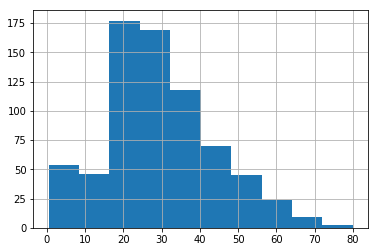

In [421]:
train_data["Age"].hist()

In [422]:
# Judging from the histogram of Age, we decide
# 0-20 is the first bucket
# 20-30 is the second bucket
# 30-40 is the third bucket
# 40-60 is the fourth bucket
# above 60 is the fifth bucket


In [423]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15

In [426]:
train_data.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeBucket
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S,15.0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S,15.0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S,NaN
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C,15.0
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q,30.0


In [448]:
train_data[train_data[20 < train_data[["Age"]]][["Age"]]<30]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeBucket
0,NaN,NaN,NaN,NaN,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [446]:
train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeBucket
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,15.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,30.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,15.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,30.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,30.0
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,NaN
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,45.0
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,0.0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,15.0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,0.0
